# Análisis de redes Pasco - Áncash: versión 4

In [6]:
# ============================================================
# REDES DE CONTRATACIÓN: ÁNCASH Y PASCO (2004–2024)
# Script completo: HTML + métricas en CSV
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import community as nx_comm
import json
import re

# ============================================================
# PARÁMETROS
# ============================================================
RUTA_ARCHIVO = "contratos.xlsx"      # archivo con tu data
HOJA_EXCEL = 0                       # hoja de Excel (0 = primera)
REGIONES_OBJ = ["ANCASH", "PASCO"]   # regiones incluidas
ANIO_MIN, ANIO_MAX = 2005, 2024
PRORRATEAR_MONTO_CONSORCIO = False   # True si quieres prorratear el monto entre empresas
SALIDA = Path("docs")                # carpeta base (ideal para GitHub Pages)

# carpeta para métricas
METRICS_FOLDER = SALIDA / "metrics"
METRICS_FOLDER.mkdir(parents=True, exist_ok=True)

# ============================================================
# PERIODOS DE GOBIERNO (ajusta según tu tesis)
# ============================================================
PERIODOS = [
    (pd.Timestamp("2003-01-01"), pd.Timestamp("2006-12-31"), "2003-2006"),
    (pd.Timestamp("2007-01-01"), pd.Timestamp("2010-12-31"), "2007-2010"),
    (pd.Timestamp("2011-01-01"), pd.Timestamp("2014-12-31"), "2011-2014"),
    (pd.Timestamp("2015-01-01"), pd.Timestamp("2018-12-31"), "2015-2018"),
    (pd.Timestamp("2019-01-01"), pd.Timestamp("2022-12-31"), "2019-2022"),
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2026-12-31"), "2023-2026"),
]

def asignar_periodo(fecha):
    """Asigna un nombre de periodo (ej. 2011-2014) a partir de una fecha."""
    if pd.isna(fecha):
        return None
    for ini, fin, nombre in PERIODOS:
        if ini <= fecha <= fin:
            return nombre
    return None

def slugify_periodo(p):
    """Convierte el nombre de periodo en un string amigable para archivo."""
    return str(p).replace(" ", "_").replace("/", "-")


# ============================================================
# FUNCIONES DE LIMPIEZA
# ============================================================
def _norm_region(s):
    """Normaliza nombre de región a mayúsculas sin tildes."""
    if pd.isna(s):
        return s
    s2 = str(s).strip().upper()
    for a, b in zip("ÁÉÍÓÚ", "AEIOU"):
        s2 = s2.replace(a, b)
    return s2

def _norm_emp(x):
    """Normaliza identificador de empresa (RUC, etc.)."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s = s.replace("RUC", "").replace(":", "").replace(" ", "")
    return s if s else np.nan

def _clean_monto(x):
    """Limpia montos en soles con diferentes formatos y devuelve float."""
    if pd.isna(x):
        return 0.0
    s = str(x).strip()
    s = (
        s.replace("S/","")
         .replace("s/","")
         .replace("soles","")
         .replace("SOLES","")
         .strip()
    )

    # Manejo de puntos y comas raros
    if s.count(".") > 1:
        parts = s.split(".")
        s = "".join(parts[:-1]) + "." + parts[-1]

    if "," in s and "." not in s:
        s = s.replace(",", ".")

    if s.count(",") > 0 and s.count(".") == 1:
        s = s.replace(",", "")

    s = s.replace(" ", "")

    try:
        return float(s)
    except Exception:
        t = "".join(re.findall(r"[0-9.,]", s))
        if t.count(".") > 1:
            parts = t.split(".")
            t = "".join(parts[:-1]) + "." + parts[-1]
        t = t.replace(",", "")
        try:
            return float(t)
        except Exception:
            return 0.0

def _hhi_from_values(vals):
    """
    Calcula HHI a partir de una serie de valores (por ejemplo, montos).
    HHI = sumatoria de (participación^2).
    """
    s = vals.sum()
    if s <= 0:
        return np.nan
    shares = vals / s
    return float((shares ** 2).sum())


# ============================================================
# CARGA Y LIMPIEZA DEL DATASET
# ============================================================
print("📂 Leyendo archivo:", RUTA_ARCHIVO)
df = pd.read_excel(RUTA_ARCHIVO, sheet_name=HOJA_EXCEL)

print("🧹 Limpiando columnas básicas...")
df["FECHA"] = pd.to_datetime(df["FECHA"], dayfirst=True, errors="coerce")
df["ANIO"]  = df["FECHA"].dt.year
df["REGION_NORM"] = df["REGION"].apply(_norm_region)
df["PERIODO"] = df["FECHA"].apply(asignar_periodo)

REGIONES_NORM = [_norm_region(r) for r in REGIONES_OBJ]

# Detectar columnas EMPRESA
emp_cols = [c for c in df.columns if str(c).upper().startswith("EMPRESA")]
if not emp_cols:
    raise ValueError("No hay columnas EMPRESA_n en el archivo.")

# Normalizar empresas y montos
for c in emp_cols:
    df[c] = df[c].apply(_norm_emp)

df["MONTO"] = df["MONTO"].apply(_clean_monto)

# Filtrar por regiones, años y periodos válidos
df = df[
    df["REGION_NORM"].isin(REGIONES_NORM)
    & df["ANIO"].between(ANIO_MIN, ANIO_MAX)
    & df["PERIODO"].notna()
].reset_index(drop=True)

if df.empty:
    raise ValueError("No hay registros para las regiones/años/periodos especificados.")

# ID único de contrato
df["CONTRATO_ID"] = (
    df.index.astype(str)
    + "_"
    + df["REGION_NORM"]
    + "_"
    + df["FECHA"].astype(str)
)

# número de empresas en cada contrato
df["N_EMP_CONTRATO"] = (
    df[emp_cols].notna().sum(axis=1).astype(int).replace(0, 1)
)

print("✅ Registros filtrados:", len(df))


# ============================================================
# FORMATO LARGO (contrato-empresa)
# ============================================================
print("↔️ Pasando a formato largo contrato–empresa...")

rows = []
for _, r in df.iterrows():
    anio    = int(r["ANIO"])
    periodo = r["PERIODO"]
    region  = r["REGION_NORM"]
    monto   = float(r["MONTO"])
    nemp    = int(r["N_EMP_CONTRATO"])
    cid     = r["CONTRATO_ID"]

    for c in emp_cols:
        e = r[c]
        if pd.notna(e) and str(e).strip():
            m = (monto / nemp) if PRORRATEAR_MONTO_CONSORCIO else monto
            rows.append((anio, periodo, region, e, m, cid))

long = pd.DataFrame(
    rows,
    columns=["ANIO", "PERIODO", "REGION", "EMPRESA", "MONTO_CONTRATO", "CONTRATO_ID"]
)

# Agregamos a nivel REGION–EMPRESA–PERIODO
edges = (
    long.groupby(["PERIODO", "REGION", "EMPRESA"], as_index=False)
        .agg(
            monto_total=("MONTO_CONTRATO","sum"),
            n_contratos=("CONTRATO_ID","nunique")
        )
)

PERIODOS_UNICOS = sorted(edges["PERIODO"].unique())
print("📆 Periodos encontrados:", PERIODOS_UNICOS)


# ============================================================
# HTML CON VIS-NETWORK (FUNCIÓN COMÚN)
# ============================================================
def _write_visnetwork_html(nodes, edges_list, outfile_path, title_text):
    """Escribe un HTML con vis-network a partir de listas de nodos y aristas."""
    options = {
        "nodes": {
            "borderWidth": 1,
            "shape": "dot",
            "font": {"size": 12}
        },
        "edges": {
            "smooth": {"type": "dynamic"},
            "selectionWidth": 0
        },
        "interaction": {
            "hover": True,
            "tooltipDelay": 100,
            "dragNodes": True
        },
        "physics": {
            "enabled": True,
            "stabilization": {"iterations": 800}
        }
    }

    html = f"""<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="utf-8"/>
<title>{title_text}</title>
<style>
body{{margin:0;font-family:Arial, sans-serif;background:#f7f7f7;}}
#title{{padding:10px;border-bottom:1px solid #ddd;background:#fff}}
#network{{width:100vw;height:calc(100vh - 48px);background:#f7f7f7;}}
</style>
<script src="https://unpkg.com/vis-network/standalone/umd/vis-network.min.js"></script>
</head>
<body>
<div id="title">{title_text}</div>
<div id="network"></div>
<script>
const nodes = new vis.DataSet({json.dumps(nodes, ensure_ascii=False)});
const edges = new vis.DataSet({json.dumps(edges_list, ensure_ascii=False)});
const container = document.getElementById('network');
const data = {{ nodes, edges }};
const options = {json.dumps(options)};
const network = new vis.Network(container, data, options);

// dejar que se estabilice y luego apagar física
network.once('stabilizationIterationsDone', function () {{
  network.setOptions({{ physics: false }});
}});
</script>
</body>
</html>
"""
    Path(outfile_path).write_text(html, encoding="utf-8")


# ============================================================
# BIPARTITO REGIÓN–EMPRESA POR PERIODO
# ============================================================
def build_graph_for_period(periodo):
    """
    Construye el grafo bipartito REGIÓN–EMPRESA para un periodo:
      - G: bipartito
      - H: proyección empresa–empresa vía consorcios (solo para bet/clo de empresas)
    Devuelve:
      - nodes (para HTML)
      - edges_list (para HTML)
      - stats (dict de métricas globales)
      - df_nodes (DataFrame de métricas por nodo)
    """
    dfa = edges[edges["PERIODO"] == periodo].copy()
    if dfa.empty:
        stats = {
            "periodo": periodo,
            "n_regiones": 0,
            "n_empresas": 0,
            "n_contratos": 0,
            "density": float("nan"),
            "avg_degree": float("nan"),
            "n_components": 0,
            "size_lcc": 0,
            "diameter_lcc": float("nan"),
            "avg_path_lcc": float("nan"),
            "modularity_empresas": float("nan"),
            "hhi_monto_global": float("nan"),
        }
        return [], [], stats, pd.DataFrame()

    # ---------- 1) GRAFO BIPARTITO Región–Empresa ----------
    G = nx.Graph()

    for reg in dfa["REGION"].unique():
        G.add_node(reg, tipo="region", label=reg.title())

    for emp in dfa["EMPRESA"].unique():
        G.add_node(emp, tipo="empresa", label=str(emp))

    for _, r in dfa.iterrows():
        reg = r["REGION"]
        emp = r["EMPRESA"]
        w   = int(r["n_contratos"])
        mt  = float(r["monto_total"])

        if G.has_edge(reg, emp):
            G[reg][emp]["weight"]      += w
            G[reg][emp]["monto_total"] += mt
        else:
            G.add_edge(reg, emp, weight=w, monto_total=mt)

    # Métricas bipartitas (en G)
    deg_bip  = dict(G.degree())
    degw_bip = dict(G.degree(weight="weight"))
    bet_bip  = nx.betweenness_centrality(G, weight="weight")
    clo_bip  = nx.closeness_centrality(G)

    # ---------- 2) GRAFO CO-CONTRATACIÓN (H) SOLO PARA EMPRESAS ----------
    long_p = long[long["PERIODO"] == periodo].copy()
    H = nx.Graph()

    for cid, g in long_p.groupby("CONTRATO_ID"):
        emps = list(g["EMPRESA"].dropna().unique())
        if len(emps) < 2:
            continue
        for i in range(len(emps)):
            for j in range(i + 1, len(emps)):
                e1, e2 = emps[i], emps[j]
                if H.has_edge(e1, e2):
                    H[e1][e2]["weight"] += 1
                else:
                    H.add_edge(e1, e2, weight=1)

    if H.number_of_nodes() > 0:
        bet_co = nx.betweenness_centrality(H, weight="weight")
        clo_co = nx.closeness_centrality(H)
        # modularidad sobre el componente principal de empresas
        largest_cc_H = max(nx.connected_components(H), key=len)
        H_lcc = H.subgraph(largest_cc_H).copy()
        comms = nx_comm.greedy_modularity_communities(H_lcc, weight="weight")
        modularity_empresas = nx_comm.modularity(H_lcc, comms, weight="weight")
    else:
        bet_co, clo_co = {}, {}
        modularity_empresas = float("nan")

    # ---------- 3) MÉTRICAS GLOBALES DEL BIPARTITO ----------
    total_contr = int(dfa["n_contratos"].sum())
    n_empresas  = int(dfa["EMPRESA"].nunique())
    n_regiones  = int(dfa["REGION"].nunique())
    dens        = float(nx.density(G)) if G.number_of_nodes() > 1 else float("nan")

    # grado promedio
    if G.number_of_nodes() > 0:
        avg_degree = float(np.mean(list(deg_bip.values())))
    else:
        avg_degree = float("nan")

    # componentes, diámetro y caminos en el componente principal
    if G.number_of_nodes() > 0:
        components = list(nx.connected_components(G))
        n_components = len(components)
        largest_cc = max(components, key=len)
        size_lcc = len(largest_cc)
        if size_lcc > 1:
            G_lcc = G.subgraph(largest_cc).copy()
            try:
                diameter_lcc = float(nx.diameter(G_lcc))
            except Exception:
                diameter_lcc = float("nan")
            try:
                avg_path_lcc = float(nx.average_shortest_path_length(G_lcc))
            except Exception:
                avg_path_lcc = float("nan")
        else:
            diameter_lcc = float("nan")
            avg_path_lcc = float("nan")
    else:
        n_components = 0
        size_lcc = 0
        diameter_lcc = float("nan")
        avg_path_lcc = float("nan")

    # HHI de concentración (global, sobre montos)
    hhi_global = _hhi_from_values(dfa["monto_total"])

    stats = {
        "periodo": periodo,
        "n_regiones": n_regiones,
        "n_empresas": n_empresas,
        "n_contratos": total_contr,
        "density": dens,
        "avg_degree": avg_degree,
        "n_components": n_components,
        "size_lcc": size_lcc,
        "diameter_lcc": diameter_lcc,
        "avg_path_lcc": avg_path_lcc,
        "modularity_empresas": modularity_empresas,
        "hhi_monto_global": hhi_global,
    }

    # ---------- 4) NODOS PARA HTML + TABLA DE NODOS ----------
    nodes = []
    rows_nodes = []

    for n in G.nodes():
        tipo  = G.nodes[n]["tipo"]
        label = G.nodes[n]["label"]

        if tipo == "region":
            bet_v_bip = bet_bip.get(n, 0.0)
            clo_v_bip = clo_bip.get(n, 0.0)
            bet_v_co  = np.nan
            clo_v_co  = np.nan
            size  = 40
            color = "#1f77b4"
        else:
            bet_v_bip = bet_bip.get(n, 0.0)
            clo_v_bip = clo_bip.get(n, 0.0)
            bet_v_co  = bet_co.get(n, 0.0)
            clo_v_co  = clo_co.get(n, 0.0)
            size  = 6 + 2 * degw_bip.get(n, 1)
            color = "#FFD12A"

        tipo_txt = "Región" if tipo == "region" else "Empresa"

        title = (
            f"{tipo_txt}: {label}<br>"
            f"Degree (bipartito): {deg_bip.get(n,0)}<br>"
            f"Degree ponderado (# contratos): {degw_bip.get(n,0)}<br>"
            f"Betweenness (bip): {bet_v_bip:.3f} | Closeness (bip): {clo_v_bip:.3f}<br>"
            f"Betweenness (co): {bet_v_co:.3f} | Closeness (co): {clo_v_co:.3f}"
        )

        nodes.append({
            "id": n,
            "label": label,
            "shape": "circle" if tipo == "region" else "dot",
            "size": size,
            "color": color,
            "title": title,
            "group": tipo,
        })

        rows_nodes.append({
            "periodo": periodo,
            "nodo": n,
            "label": label,
            "tipo": tipo,
            "degree_bip": deg_bip.get(n, 0),
            "degreew_bip": degw_bip.get(n, 0),
            "betweenness_bip": bet_v_bip,
            "closeness_bip": clo_v_bip,
            "betweenness_co": bet_v_co,
            "closeness_co": clo_v_co,
        })

    df_nodes = pd.DataFrame(rows_nodes)

    # ---------- 5) ARISTAS ----------
    edges_list = []
    for u, v, data in G.edges(data=True):
        w  = int(data.get("weight", 1))
        mt = float(data.get("monto_total", 0.0))
        width = 1 + min(4, 0.4 * w)
        title = f"# contratos: {w} | Monto total: S/ {mt:,.2f}"
        edges_list.append({
            "from": u,
            "to": v,
            "value": w,
            "width": width,
            "title": title,
        })

    return nodes, edges_list, stats, df_nodes


def save_period_html_bipartito(periodo, folder=SALIDA):
    """Genera el HTML bipartito para un periodo y guarda métricas de nodos."""
    dfa = edges[edges["PERIODO"] == periodo]
    if dfa.empty:
        return None

    nodes, edges_list, stats, df_nodes = build_graph_for_period(periodo)
    title = f"Red de contratación — {', '.join(REGIONES_OBJ)} — {periodo}"

    folder.mkdir(parents=True, exist_ok=True)
    name = f"red_{slugify_periodo(periodo)}.html"
    path = str(folder / name)

    _write_visnetwork_html(nodes, edges_list, path, title)

    # guardamos tabla de nodos por periodo
    df_nodes.to_csv(
        METRICS_FOLDER / f"nodos_bip_{slugify_periodo(periodo)}.csv",
        index=False
    )

    return name, stats


# ============================================================
# GENERAR HTMLs BIPARTITOS + INDEX + RESUMEN CSV
# ============================================================
print("🕸 Generando redes bipartitas por periodo...")

items = []

for p in PERIODOS_UNICOS:
    res = save_period_html_bipartito(p)
    if res:
        fname, st = res
        items.append({
            "p": str(st["periodo"]),
            "f": fname,
            "density": float(st["density"]) if pd.notna(st["density"]) else None,
            "n_regiones": int(st["n_regiones"]),
            "n_empresas": int(st["n_empresas"]),
            "n_contratos": int(st["n_contratos"]),
            "avg_degree": st["avg_degree"],
            "n_components": st["n_components"],
            "size_lcc": st["size_lcc"],
            "diameter_lcc": st["diameter_lcc"],
            "avg_path_lcc": st["avg_path_lcc"],
            "modularity_empresas": st["modularity_empresas"],
            "hhi_monto_global": st["hhi_monto_global"],
        })

print("HTMLs bipartitos generados:", [it["f"] for it in items])

# tabla resumen de periodos bipartitos
df_periodos_bip = pd.DataFrame(items)
df_periodos_bip.to_csv(METRICS_FOLDER / "resumen_bipartito_periodos.csv", index=False)

# index HTML bipartito
SALIDA.mkdir(parents=True, exist_ok=True)
index_path = SALIDA / "index.html"
items_js = json.dumps(items, ensure_ascii=False)

index_code = """<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="utf-8"/>
<title>Redes de contratación por periodo (bipartito)</title>
<style>
body{font-family:system-ui,-apple-system,Segoe UI,Roboto,Arial,sans-serif;margin:0;padding:20px;background:#f5f5f5;}
.container{max-width:1200px;margin:0 auto;}
h2{margin-top:0;margin-bottom:10px;}
iframe{width:100%;height:80vh;border:1px solid #ddd;border-radius:8px;background:#fff;}
.bar{display:flex;gap:10px;align-items:center;flex-wrap:wrap;margin-bottom:15px;}
select,button{padding:6px 10px;border-radius:6px;border:1px solid #ccc;background:#fff;cursor:pointer;}
button:hover{background:#f0f0f0;}
.kpi{background:#fff;border:1px solid #ddd;padding:6px 12px;border-radius:6px;}
</style>
</head>
<body>
<div class="container">
  <h2>Redes de contratación — Regiones y empresas por periodo</h2>
  <div class="bar">
    <button onclick="prev()">⟨ Anterior</button>
    <label for="period">Periodo:</label>
    <select id="period" onchange="go(this.value)"></select>
    <button onclick="next()">Siguiente ⟩</button>
    <span class="kpi" id="kpi"></span>
  </div>
  <iframe id="view" src="" loading="lazy"></iframe>
</div>
<script>
const items = __ITEMS__;
let idx = 0;

function fillSelect(){
  const sel = document.getElementById("period");
  sel.innerHTML = "";
  items.forEach((it,i)=>{
    const o = document.createElement("option");
    o.value = i;
    o.textContent = it.p;
    sel.appendChild(o);
  });
}

function updateKPI(){
  const it = items[idx];
  const dens = (it.density !== null && !isNaN(it.density)) ? it.density.toFixed(4) : "—";
  document.getElementById("kpi").innerHTML =
    "<b>Densidad:</b> "+dens+
    " | <b>Regiones:</b> "+it.n_regiones+
    " | <b>Empresas:</b> "+it.n_empresas+
    " | <b>Contratos:</b> "+it.n_contratos;
}

function load(){
  if(!items.length) return;
  const it = items[idx];
  document.getElementById("view").src = it.f;
  document.getElementById("period").selectedIndex = idx;
  updateKPI();
}

function go(i){ idx = parseInt(i); load(); }
function prev(){ idx = (idx - 1 + items.length) % items.length; load(); }
function next(){ idx = (idx + 1) % items.length; load(); }

fillSelect();
load();
</script>
</body>
</html>
"""

index_code = index_code.replace("__ITEMS__", items_js)
index_path.write_text(index_code, encoding="utf-8")
print("✅ Index bipartito generado en:", index_path.resolve())


# ============================================================
# PROYECCIÓN EMPRESA–EMPRESA (CONSORCIOS)
# ============================================================

def _interp_color(c1, c2, t):
    """Interpolación lineal entre dos colores RGB (0–255), retorna hex."""
    r = int(c1[0] + (c2[0]-c1[0]) * t)
    g = int(c1[1] + (c2[1]-c1[1]) * t)
    b = int(c1[2] + (c2[2]-c1[2]) * t)
    return f"#{r:02X}{g:02X}{b:02X}"

def build_empresa_projection(periodo):
    """
    Red 1-modo de EMPRESAS:
      - Nodos: empresas
      - Aristas: empresas que fueron juntas en al menos un contrato (consorcio)
      - Peso: # de contratos compartidos

    Devuelve:
      - nodes (para HTML)
      - edges_list (para HTML)
      - stats (métricas globales de la red de empresas)
      - df_nodes (métricas por empresa)
    """
    long_p = long[long["PERIODO"] == periodo].copy()

    H = nx.Graph()
    n_consortios = 0

    for cid, g in long_p.groupby("CONTRATO_ID"):
        emps = list(g["EMPRESA"].dropna().unique())
        if len(emps) < 2:
            continue  # sin consorcio
        n_consortios += 1
        for i in range(len(emps)):
            for j in range(i + 1, len(emps)):
                e1, e2 = emps[i], emps[j]
                if H.has_edge(e1, e2):
                    H[e1][e2]["weight"] += 1
                else:
                    H.add_edge(e1, e2, weight=1)

    if H.number_of_nodes() == 0:
        stats = {
            "periodo": periodo,
            "n_empresas": 0,
            "n_aristas": 0,
            "n_consortios": 0,
            "density": float("nan"),
            "avg_degree": float("nan"),
            "avg_clustering": float("nan"),
        }
        return [], [], stats, pd.DataFrame()

    # Métricas de la red de empresas
    deg   = dict(H.degree())
    deg_w = dict(H.degree(weight="weight"))
    bet   = nx.betweenness_centrality(H, weight="weight")
    clo   = nx.closeness_centrality(H)

    n_empresas = H.number_of_nodes()
    n_aristas  = H.number_of_edges()
    dens       = float(nx.density(H))
    avg_degree = float(np.mean(list(deg.values())))
    avg_clustering = float(nx.average_clustering(H, weight="weight"))

    stats = {
        "periodo": periodo,
        "n_empresas": n_empresas,
        "n_aristas": n_aristas,
        "n_consortios": n_consortios,
        "density": dens,
        "avg_degree": avg_degree,
        "avg_clustering": avg_clustering,
    }

    # Para color según intensidad: normalizamos degree ponderado
    max_deg_w = max(deg_w.values()) if deg_w else 1
    light = (255, 239, 179)  # amarillo clarito
    dark  = (255, 140,   0)  # naranja fuerte

    nodes = []
    rows_nodes = []
    for n in H.nodes():
        dw = deg_w.get(n, 0)
        t  = dw / max_deg_w if max_deg_w > 0 else 0
        color = _interp_color(light, dark, t)

        size = 6 + 2 * dw
        title = (
            f"Empresa: {n}<br>"
            f"Degree (co-contratación): {deg.get(n,0)}<br>"
            f"Degree ponderado (# contratos en consorcio): {dw}<br>"
            f"Betweenness: {bet.get(n,0):.3f} | Closeness: {clo.get(n,0):.3f}"
        )
        nodes.append({
            "id": n,
            "label": str(n),
            "shape": "dot",
            "size": size,
            "color": {"background": color, "border": "#AA7A00"},
            "title": title
        })

        rows_nodes.append({
            "periodo": periodo,
            "empresa": n,
            "degree_co": deg.get(n, 0),
            "degreew_co": dw,
            "betweenness_co": bet.get(n, 0.0),
            "closeness_co": clo.get(n, 0.0),
        })

    df_nodes = pd.DataFrame(rows_nodes)

    edges_list = []
    for u, v, data in H.edges(data=True):
        w = int(data.get("weight", 1))
        width = 1 + min(4, 0.5 * w)
        title = f"# contratos compartidos (consorcios): {w}"
        edges_list.append({
            "from": u,
            "to": v,
            "value": w,
            "width": width,
            "title": title,
        })

    return nodes, edges_list, stats, df_nodes


def save_period_html_empresas(periodo, folder=SALIDA):
    """Genera HTML de proyección de empresas y guarda métricas de nodos."""
    nodes, edges_list, stats, df_nodes = build_empresa_projection(periodo)
    if not nodes:
        return None

    title = f"Proyección sobre empresas — consorcios — {periodo}"

    folder.mkdir(parents=True, exist_ok=True)
    name = f"empresas_consorcios_{slugify_periodo(periodo)}.html"
    path = str(folder / name)

    _write_visnetwork_html(nodes, edges_list, path, title)

    # guardamos tabla de nodos de empresas por periodo
    df_nodes.to_csv(
        METRICS_FOLDER / f"nodos_empresas_consorcios_{slugify_periodo(periodo)}.csv",
        index=False
    )

    return name, stats


# ============================================================
# GENERAR HTMLs PROYECCIÓN EMPRESAS + INDEX + RESUMEN CSV
# ============================================================
print("🏗 Generando redes de co-contratación de empresas por periodo...")

items_emp = []

for p in PERIODOS_UNICOS:
    res = save_period_html_empresas(p)
    if res:
        fname, st = res
        items_emp.append({
            "p": str(st["periodo"]),
            "f": fname,
            "density": float(st["density"]) if pd.notna(st["density"]) else None,
            "n_empresas": int(st["n_empresas"]),
            "n_aristas": int(st["n_aristas"]),
            "n_consortios": int(st["n_consortios"]),
            "avg_degree": st["avg_degree"],
            "avg_clustering": st["avg_clustering"],
        })

print("HTMLs proyección empresas generados:", [it["f"] for it in items_emp])

# tabla resumen de proyección empresas
df_periodos_emp = pd.DataFrame(items_emp)
df_periodos_emp.to_csv(METRICS_FOLDER / "resumen_empresas_periodos.csv", index=False)

# index HTML empresas
index_emp_path = SALIDA / "index_empresas.html"
items_emp_js = json.dumps(items_emp, ensure_ascii=False)

index_emp_code = """<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="utf-8"/>
<title>Proyección sobre empresas — consorcios</title>
<style>
body{font-family:system-ui,-apple-system,Segoe UI,Roboto,Arial,sans-serif;margin:0;padding:20px;background:#f5f5f5;}
.container{max-width:1200px;margin:0 auto;}
h2{margin-top:0;margin-bottom:10px;}
iframe{width:100%;height:80vh;border:1px solid #ddd;border-radius:8px;background:#fff;}
.bar{display:flex;gap:10px;align-items:center;flex-wrap:wrap;margin-bottom:15px;}
select,button{padding:6px 10px;border-radius:6px;border:1px solid #ccc;background:#fff;cursor:pointer;}
button:hover{background:#f0f0f0;}
.kpi{background:#fff;border:1px solid #ddd;padding:6px 12px;border-radius:8px;}
</style>
</head>
<body>
<div class="container">
  <h2>Proyección sobre empresas — Consorcios por periodo</h2>
  <div class="bar">
    <button onclick="prev()">⟨ Anterior</button>
    <label for="period_emp">Periodo:</label>
    <select id="period_emp" onchange="go(this.value)"></select>
    <button onclick="next()">Siguiente ⟩</button>
    <span class="kpi" id="kpi_emp"></span>
  </div>
  <iframe id="view_emp" src="" loading="lazy"></iframe>
</div>
<script>
const items = __ITEMS_EMP__;
let idx = 0;

function fillSelect(){
  const sel = document.getElementById("period_emp");
  sel.innerHTML = "";
  items.forEach((it,i)=>{
    const o = document.createElement("option");
    o.value = i;
    o.textContent = it.p;
    sel.appendChild(o);
  });
}

function updateKPI(){
  const it = items[idx];
  const dens = (it.density !== null && !isNaN(it.density)) ? it.density.toFixed(4) : "—";
  document.getElementById("kpi_emp").innerHTML =
    "<b>Densidad:</b> "+dens+
    " | <b>Empresas:</b> "+it.n_empresas+
    " | <b>Aristas (pares de empresas):</b> "+it.n_aristas+
    " | <b>Contratos en consorcio:</b> "+it.n_consortios;
}

function load(){
  if(!items.length) return;
  const it = items[idx];
  document.getElementById("view_emp").src = it.f;
  document.getElementById("period_emp").selectedIndex = idx;
  updateKPI();
}

function go(i){ idx = parseInt(i); load(); }
function prev(){ idx = (idx - 1 + items.length) % items.length; load(); }
function next(){ idx = (idx + 1) % items.length; load(); }

fillSelect();
load();
</script>
</body>
</html>
"""

index_emp_code = index_emp_code.replace("__ITEMS_EMP__", items_emp_js)
index_emp_path.write_text(index_emp_code, encoding="utf-8")
print("✅ Index empresas generado en:", index_emp_path.resolve())

print("🎉 Listo. Revisa la carpeta:", SALIDA.resolve())
print("   - HTMLs de redes en docs/")
print("   - Métricas en CSV en docs/metrics/")


📂 Leyendo archivo: contratos.xlsx
🧹 Limpiando columnas básicas...
✅ Registros filtrados: 1069
↔️ Pasando a formato largo contrato–empresa...
📆 Periodos encontrados: ['2003-2006', '2007-2010', '2011-2014', '2015-2018', '2019-2022', '2023-2026']
🕸 Generando redes bipartitas por periodo...
HTMLs bipartitos generados: ['red_2003-2006.html', 'red_2007-2010.html', 'red_2011-2014.html', 'red_2015-2018.html', 'red_2019-2022.html', 'red_2023-2026.html']
✅ Index bipartito generado en: C:\Users\aaro\OneDrive - APOYO COMUNICACION\Documentos\GitHub\Tesis_Redes\Redes_Pasco_Ancash_Vgraficosunidos_soloeso\docs\index.html
🏗 Generando redes de co-contratación de empresas por periodo...
HTMLs proyección empresas generados: ['empresas_consorcios_2003-2006.html', 'empresas_consorcios_2007-2010.html', 'empresas_consorcios_2011-2014.html', 'empresas_consorcios_2015-2018.html', 'empresas_consorcios_2019-2022.html', 'empresas_consorcios_2023-2026.html']
✅ Index empresas generado en: C:\Users\aaro\OneDrive - AP

✅ Figura multipanel guardada en: C:\Users\aaro\OneDrive - APOYO COMUNICACION\Documentos\GitHub\Tesis_Redes\Redes_Pasco_Ancash_Vgraficosunidos_soloeso\docs\empresas_multipanel.png


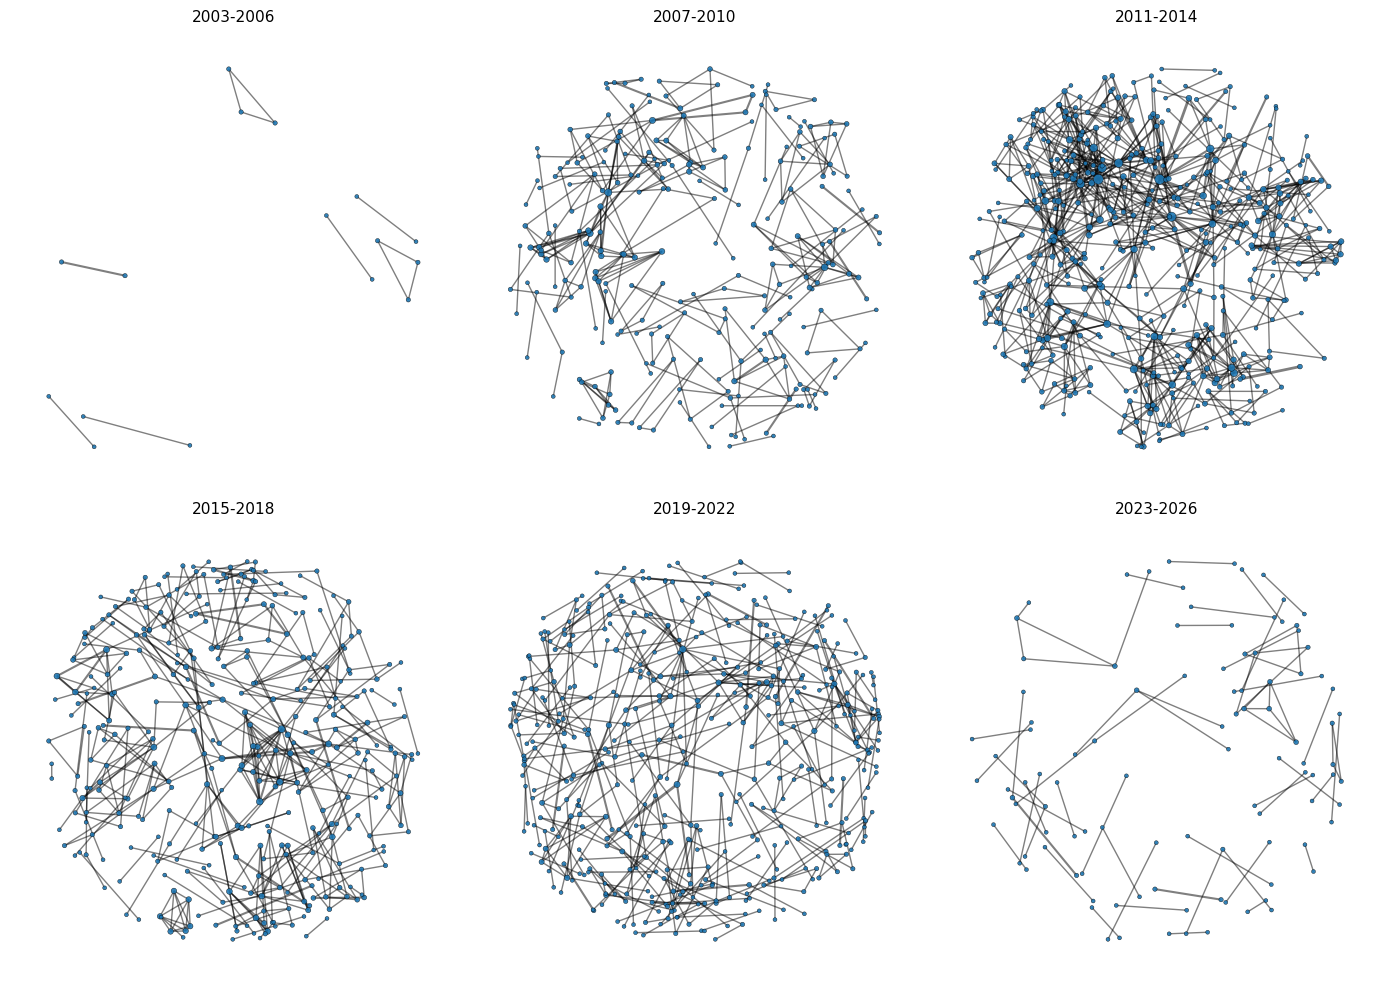

In [7]:
# ============================================================
# FIGURA ESTÁTICA: 6 REDES EMPRESA–EMPRESA EN PANELES
# ============================================================
import matplotlib.pyplot as plt

def build_empresa_graph(periodo):
    """
    Devuelve el grafo de co-contratación (empresas) para un periodo.
    Nodos: empresas
    Aristas: empresas que comparten al menos un contrato (consorcio)
    Peso: número de contratos compartidos
    """
    long_p = long[long["PERIODO"] == periodo].copy()
    H = nx.Graph()

    for cid, g in long_p.groupby("CONTRATO_ID"):
        emps = list(g["EMPRESA"].dropna().unique())
        if len(emps) < 2:
            continue
        for i in range(len(emps)):
            for j in range(i + 1, len(emps)):
                e1, e2 = emps[i], emps[j]
                if H.has_edge(e1, e2):
                    H[e1][e2]["weight"] += 1
                else:
                    H.add_edge(e1, e2, weight=1)
    return H

def build_global_layout(periodos):
    """
    Construye un layout común para todas las redes de los periodos indicados,
    usando el grafo unión de todos ellos. Así las posiciones de los nodos
    son comparables entre paneles (como en la figura de ejemplo).
    """
    long_p = long[long["PERIODO"].isin(periodos)].copy()
    H_all = nx.Graph()

    for cid, g in long_p.groupby("CONTRATO_ID"):
        emps = list(g["EMPRESA"].dropna().unique())
        if len(emps) < 2:
            continue
        for i in range(len(emps)):
            for j in range(i + 1, len(emps)):
                e1, e2 = emps[i], emps[j]
                if not H_all.has_edge(e1, e2):
                    H_all.add_edge(e1, e2)

    # layout global
    pos = nx.spring_layout(H_all, k=0.2, seed=42)
    return pos

# --- elige los 6 periodos que quieres graficar ---
# aquí tomo los 6 periodos de gobierno tal como los definiste
periodos_plot = sorted(PERIODOS_UNICOS)[:6]

# layout compartido para todas las redes
pos_global = build_global_layout(periodos_plot)

# figura 2x3
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

for ax, per in zip(axes.flat, periodos_plot):
    H = build_empresa_graph(per)

    if H.number_of_nodes() == 0:
        ax.set_axis_off()
        ax.set_title(str(per))
        continue

    # posiciones solo para los nodos presentes en este periodo
    pos = {n: pos_global[n] for n in H.nodes() if n in pos_global}

    # pesos para grosor de aristas y grado ponderado para tamaño de nodos
    deg_w = dict(H.degree(weight="weight"))
    edges = H.edges()
    weights = [H[u][v]['weight'] for u, v in edges]

    # nodos
    node_sizes = [6 + 2 * deg_w.get(n, 1) for n in H.nodes()]
    nx.draw_networkx_nodes(
        H, pos, ax=ax,
        node_size=node_sizes,
        linewidths=0.3,
        edgecolors="black",
        alpha=0.9
    )

    # aristas
    edge_widths = [0.5 + 0.5 * w for w in weights]
    nx.draw_networkx_edges(
        H, pos, ax=ax,
        width=edge_widths,
        alpha=0.5
    )

    ax.set_title(str(per), fontsize=11)
    ax.set_axis_off()

plt.tight_layout()
# guarda la imagen en la carpeta docs/
fig_path = SALIDA / "empresas_multipanel.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print("✅ Figura multipanel guardada en:", fig_path.resolve())


✅ Figura multipanel bipartita guardada en: C:\Users\aaro\OneDrive - APOYO COMUNICACION\Documentos\GitHub\Tesis_Redes\Redes_Pasco_Ancash_Vgraficosunidos_soloeso\docs\bipartito_multipanel.png


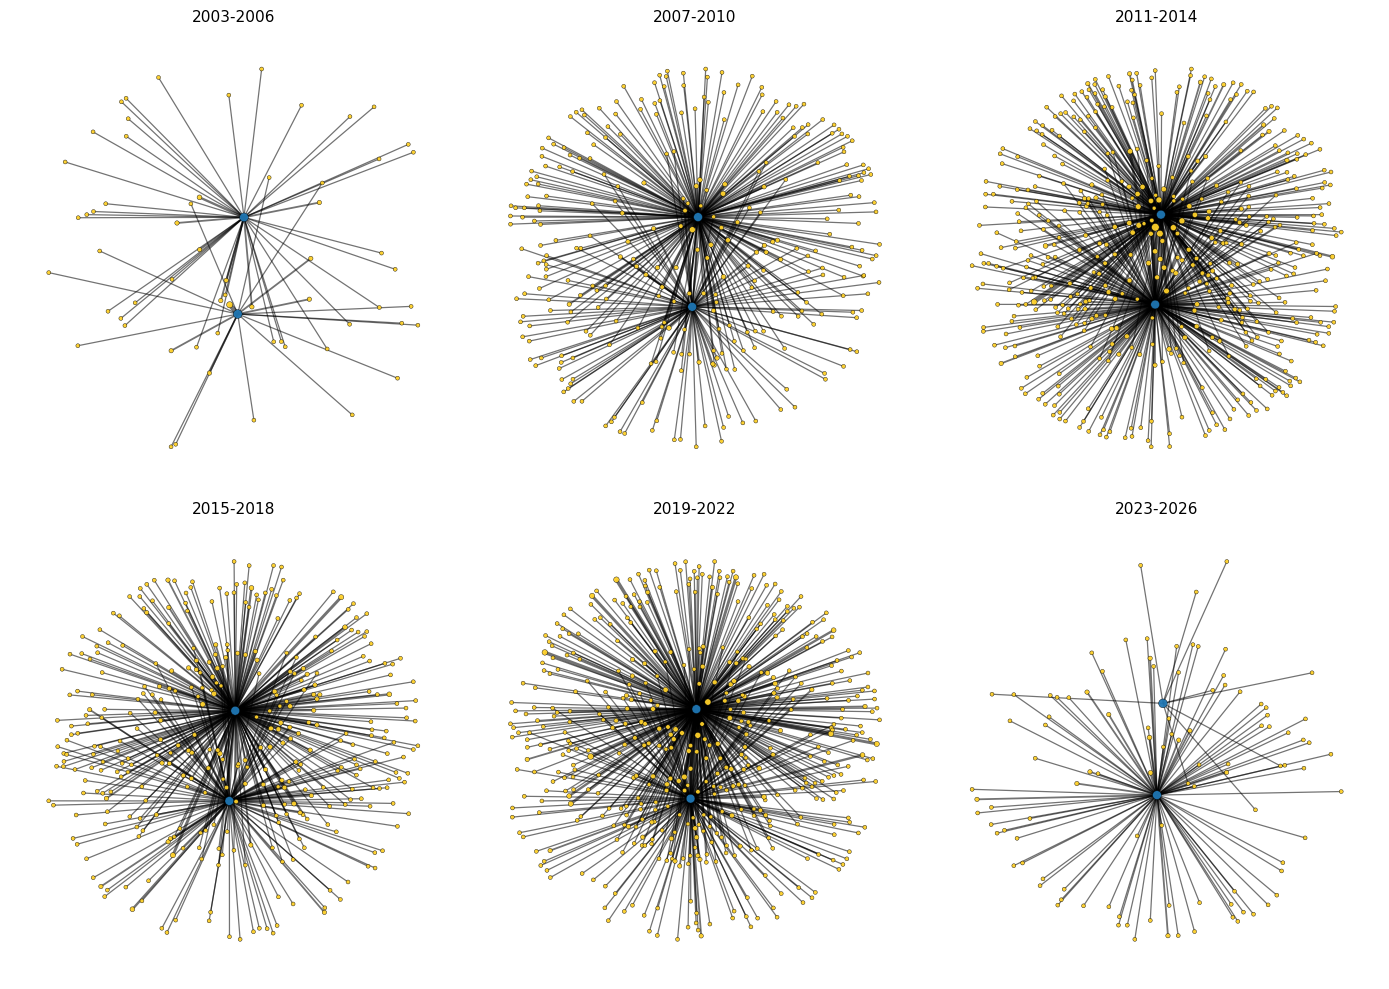

In [11]:
# ============================================================
# FIGURA ESTÁTICA: 6 REDES BIPARTITAS (REGIÓN–EMPRESA)
# ============================================================

def build_bipartito_graph(periodo):
    """
    Construye el grafo bipartito REGIÓN–EMPRESA para un periodo
    directamente desde 'long' (sin usar la variable global 'edges').
    Nodos: regiones y empresas
    Aristas: contratos entre región y empresa
    Peso: número de contratos (n_contratos)
    """
    long_p = long[long["PERIODO"] == periodo].copy()
    if long_p.empty:
        return nx.Graph()

    # agregamos a nivel REGION–EMPRESA–PERIODO (número de contratos)
    dfa = (
        long_p.groupby(["REGION", "EMPRESA"], as_index=False)
              .agg(n_contratos=("CONTRATO_ID", "nunique"))
    )

    G = nx.Graph()

    # nodos región
    for reg in dfa["REGION"].unique():
        G.add_node(reg, tipo="region", label=str(reg).title())

    # nodos empresa
    for emp in dfa["EMPRESA"].unique():
        G.add_node(emp, tipo="empresa", label=str(emp))

    # aristas
    for _, r in dfa.iterrows():
        reg = r["REGION"]
        emp = r["EMPRESA"]
        w   = int(r["n_contratos"])
        if G.has_edge(reg, emp):
            G[reg][emp]["weight"] += w
        else:
            G.add_edge(reg, emp, weight=w)

    return G


def build_global_layout_bip(periodos):
    """
    Layout global para todas las redes bipartitas de los periodos
    seleccionados, para que las posiciones sean comparables.
    """
    H_all = nx.Graph()

    for p in periodos:
        H = build_bipartito_graph(p)
        H_all.add_nodes_from(H.nodes(data=True))
        for u, v, data in H.edges(data=True):
            if not H_all.has_edge(u, v):
                H_all.add_edge(u, v, weight=data.get("weight", 1))

    if H_all.number_of_nodes() == 0:
        return {}

    pos = nx.spring_layout(H_all, k=0.22, seed=42)
    return pos


# --- seleccionamos los 6 periodos ---
periodos_plot_bip = sorted(PERIODOS_UNICOS)[:6]

# layout común
pos_global_bip = build_global_layout_bip(periodos_plot_bip)

# figura 2x3
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

for ax, per in zip(axes.flat, periodos_plot_bip):
    H = build_bipartito_graph(per)

    if H.number_of_nodes() == 0 or not pos_global_bip:
        ax.set_axis_off()
        ax.set_title(str(per))
        continue

    pos = {n: pos_global_bip[n] for n in H.nodes() if n in pos_global_bip}

    # tamaños de nodos (regiones grandes, empresas proporcionales a grado)
    deg_w = dict(H.degree(weight="weight"))
    node_sizes = [
        40 if H.nodes[n]["tipo"] == "region" else 6 + 2 * deg_w.get(n, 1)
        for n in H.nodes()
    ]
    node_colors = [
        "#1f77b4" if H.nodes[n]["tipo"] == "region" else "#FFD12A"
        for n in H.nodes()
    ]

    nx.draw_networkx_nodes(
        H, pos, ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors="black",
        linewidths=0.3,
        alpha=0.95
    )

    weights = [H[u][v].get("weight", 1) for u, v in H.edges()]
    edge_widths = [0.5 + 0.4 * w for w in weights]

    nx.draw_networkx_edges(
        H, pos, ax=ax,
        width=edge_widths,
        alpha=0.55
    )

    ax.set_title(str(per), fontsize=11)
    ax.set_axis_off()

plt.tight_layout()

fig_path = SALIDA / "bipartito_multipanel.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print("✅ Figura multipanel bipartita guardada en:", fig_path.resolve())
